### Paquetes necesarios

In [1]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import cv2
import numpy as np
import matplotlib.pyplot as plt

# info: https://github.com/facebookresearch/segment-anything?tab=readme-ov-file
# https://segment-anything.com/demo

# instalar torch y el sam y el jupyter bbox ese


## Segmentación de toda la imagen usando SAM

In [24]:
# Cargamos el modelo. Existen tres modelos preentrenados: vit_h, vit_l, vit_b. Se descargan en el Github del proyecto.

sam = sam_model_registry['vit_h'](checkpoint="sam_vit_h_4b8939.pth") # type of models:   vit_h, vit_l, vit_b

# Abrimos la imagen
path_image = r'gato.jpg'
image = cv2.imread(path_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

c:\Users\jisal\miniconda3\envs\SAM\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [25]:
# Creamos el generador de máscaras a partir del modelo cargado anteriormente y generamos la máscara
# mask_generator = SamAutomaticMaskGenerator(
#     model=sam, # Modelo SAM a usar
#     points_per_side=32, # Set de puntos usados por el model en cada lado. El número total de puntos es points_per_side**2. 
#     pred_iou_thresh=0.86, # Umbral de IOU para considerar una region como objeto.
#     stability_score_thresh=0.92, #
#     crop_n_layers=1, # Si es mayor que 0, se hace un crop de la imagen y se procesa cada crop por separado.
#     crop_n_points_downscale_factor=2, # Points per side para los crops.
#     min_mask_region_area=100,  # Requires open-cv to run post-processing
# )
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image) # Si estamos usando CPU, esto va a tardar.

In [26]:
print(len(masks))
masks_0 = masks[0] 
print(masks_0.keys())

73
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


El mask_generator devuelve una lista de mascaras, donde cada mascara es un diccionario con distinta información:

- segmentation : La máscara propiamente dicha
- area : El área de la máscara en píxeles
- bbox : La boundary box en formato XYWH
- predicted_iou : La predicción de IOU del modelo para dicha máscara
- point_coords : Los puntos usados de input para generar la máscara
- stability_score : Otra forma de evaluar la calidad de la máscara
- crop_box : el cropeo de la imagen usado para generar dicha máscara en el mismo formato que bbox.

In [51]:
# Vamos a hacer una función para visualizar las máscaras
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

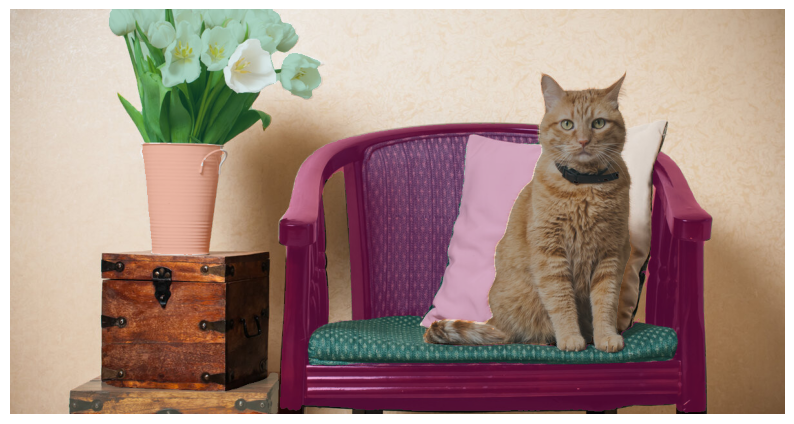

In [63]:

# no te dice que es cada mascara, solo segmenta los diferentes objetos que el ve
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks[2:10]) # vamos a mostrar un segmento de las mascaras
plt.axis('off')
plt.show() 

### Segmentar a partir de un promt

Vamos a darle unas bounding boxes como promt a SAM

In [64]:
from segment_anything import SamPredictor, sam_model_registry

predictor = SamPredictor(sam)
predictor.set_image(image)


In [ ]:
from jupyter_bbox_widget import BBoxWidget
widget = BBoxWidget( image = path_image) # Generamos el widget para dibujar los bounding boxes. Hay que clickar submit cada vez que se dibuja una.
widget



BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [93]:
# Lista con las bounding boxes creadas
print(widget.bboxes)

[{'x': 626, 'y': 86, 'width': 362, 'height': 438, 'label': ''}, {'x': 117, 'y': 4, 'width': 399, 'height': 375, 'label': ''}, {'x': 98, 'y': 374, 'width': 322, 'height': 222, 'label': ''}]


In [ ]:
# Elegimos cual de las bboxes queremos usar

box = widget.bboxes[1]
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [91]:
masks, scores, logits = predictor.predict(
    box=box,
    multimask_output=False)

print (masks.shape) # Mascara binaria de la imagen
print (scores) # Score de la máscara
print (logits) # Logits de la máscara

(1, 627, 1200)
[0.93091744]
[[[-15.66279  -17.302233 -15.239507 ... -15.859021 -18.144365 -16.925644]
  [-19.363495 -23.754095 -19.499323 ... -18.64037  -19.417698 -19.056135]
  [-19.136255 -21.760136 -16.744835 ... -15.772065 -17.994545 -17.486961]
  ...
  [-20.297985 -24.693405 -19.687714 ... -18.91469  -17.474474 -17.403143]
  [-24.945742 -23.088905 -25.00038  ... -16.022661 -18.789806 -17.062326]
  [-18.756155 -23.469662 -18.747852 ... -17.004707 -17.110298 -16.336874]]]


In [87]:
# Vamos a hacer dos funciones para visualizar las máscaras y las bounding boxes
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

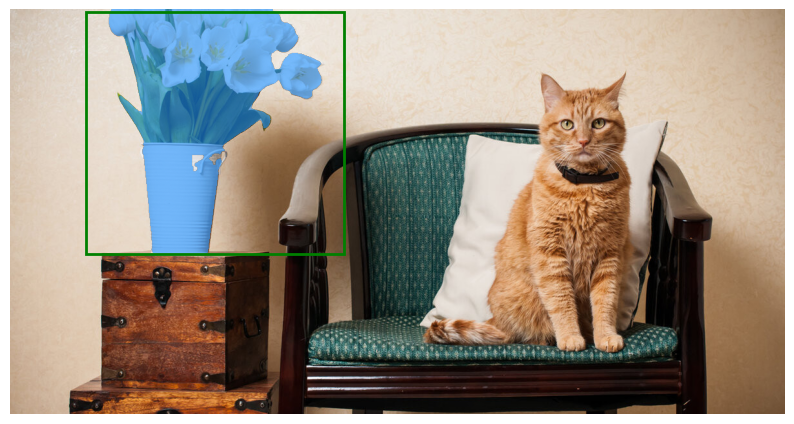

In [88]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(box, plt.gca())
plt.axis('off')
plt.show()